In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM, BatchNormalization,MaxPooling2D,Reshape, GRU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy").reshape(2115)
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443, 1)


In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

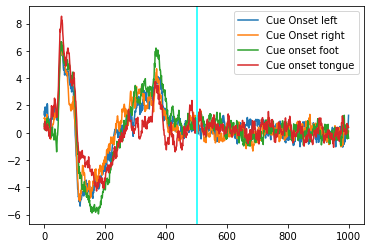

In [5]:

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])




In [6]:
from scipy.signal import lfilter
n = 10
b = [1/n]*n
a = 1
X_train_valid_n = np.zeros((X_train_valid.shape))
for i in range(X_train_valid.shape[0]):
    for j in range(X_train_valid.shape[1]):
        X_train_valid_n[i,j,:] = lfilter(b,a,X_train_valid[i,j,:])
X_test_n = np.zeros((X_test.shape))
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test_n[i,j,:] = lfilter(b,a,X_test[i,j,:])
    
        

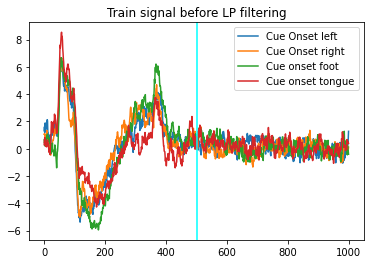

In [7]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

# y_train_valid -= 769
# y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.title('Train signal before LP filtering')
plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])




In [8]:
from scipy.signal import lfilter
n = 10
b = [1/n]*n
a = 1
def data_prep(X,y,p,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_p = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    X_n = np.zeros((X.shape))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_n[i,j,:] = lfilter(b,a,X[i,j,:])

    X = np.vstack((X, X_n))
    y = np.hstack((y, y))
    p = np.hstack((p, p))
    
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_p = p

    print('Shape of X after maxpooling:',total_X.shape)
    print('Shape of X after maxpooling:',total_y.shape)
    print('Shape of X after maxpooling:',total_p.shape)

    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.hstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.hstack((total_p, p))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y, total_p




In [9]:
## Preprocessing the dataset
X_train_valid_prep,y_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)
X_test_prep,y_test_prep,person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)
stratif_labels = []
for i in range(person_train_valid_prep.shape[0]):
    stratif_labels.append(str(person_train_valid_prep[i].astype('int'))+str(y_train_valid_prep[i]))
print(person_train_valid_prep.shape)
print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

# Splitting based on stratified sampling
x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid_prep,y_train_valid_prep,test_size=1500/8460,stratify=stratif_labels,random_state=20)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
print(y_test.shape)

Shape of X after trimming: (4230, 22, 500)
Shape of X after maxpooling: (4230, 22, 250)
Shape of X after maxpooling: (4230,)
Shape of X after maxpooling: (4230,)
Shape of X after averaging+noise and concatenating: (8460, 22, 250)
Shape of X after subsampling and concatenating: (16920, 22, 250)
Shape of X after trimming: (886, 22, 500)
Shape of X after maxpooling: (886, 22, 250)
Shape of X after maxpooling: (886,)
Shape of X after maxpooling: (443, 2)
Shape of X after averaging+noise and concatenating: (1772, 22, 250)
Shape of X after subsampling and concatenating: (3544, 22, 250)
(16920,)
(16920, 22, 250)
(16920,)
(3544, 22, 250)
(3544,)
Shape of training set: (13920, 22, 250)
Shape of validation set: (3000, 22, 250)
Shape of training labels: (13920,)
Shape of validation labels: (3000,)
Shape of training labels after categorical conversion: (13920, 4)
Shape of validation labels after categorical conversion: (3000, 4)
Shape of test labels after categorical conversion: (3544, 4)
Shape of

In [11]:
# Building the CNN model using sequential class
from tensorflow.keras import layers
def get_3layermodel():
    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(layers.BatchNormalization())
    basic_cnn_model.add(layers.Dropout(0.6))

    # Conv. block 2
    basic_cnn_model.add(layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(layers.BatchNormalization())
    basic_cnn_model.add(layers.Dropout(0.6))

    # Conv. block 3
    basic_cnn_model.add(layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(layers.BatchNormalization())
    basic_cnn_model.add(layers.Dropout(0.6))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    return basic_cnn_model

basic_cnn_model = get_3layermodel()
# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_4 (Dropout)          (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 1, 50)        

In [12]:
learning_rate = 1.5e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate)

# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
            y_train,
            batch_size=200,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/50
70/70 [==============================] - 8s 16ms/step - loss: 1.9633 - accuracy: 0.3205 - val_loss: 1.2520 - val_accuracy: 0.4347
Epoch 2/50
70/70 [==============================] - 1s 8ms/step - loss: 1.4401 - accuracy: 0.3981 - val_loss: 1.1188 - val_accuracy: 0.5073
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 1.2169 - accuracy: 0.4783 - val_loss: 1.0712 - val_accuracy: 0.5230
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 1.1147 - accuracy: 0.5294 - val_loss: 0.9966 - val_accuracy: 0.6033
Epoch 5/50
70/70 [==============================] - 1s 8ms/step - loss: 1.0546 - accuracy: 0.5597 - val_loss: 0.9773 - val_accuracy: 0.6013
Epoch 6/50
70/70 [==============================] - 1s 8ms/step - loss: 1.0191 - accuracy: 0.5756 - val_loss: 0.9251 - val_accuracy: 0.6317
Epoch 7/50
70/70 [==============================] - 1s 8ms/step - loss: 0.9803 - accuracy: 0.5918 - val_loss: 0.9051 - val_accuracy: 0.6163
Epoch 8/50
70/70 [=

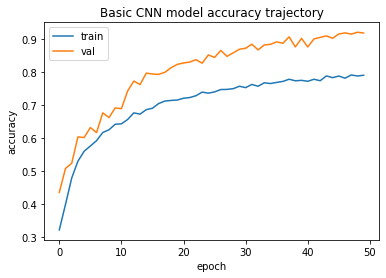

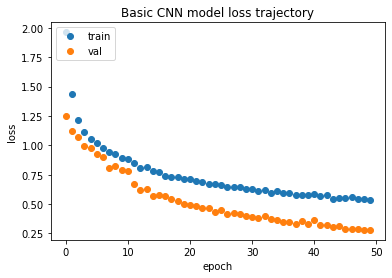

In [13]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.756771981716156


In [20]:
results = []
# Model parameters
for i in tqdm(range(50)):
    basic_cnn_model = get_3layermodel()
    learning_rate = 1.5e-3
    epochs = 50
    cnn_optimizer = keras.optimizers.Adam(learning_rate)

    # Compiling the model
    basic_cnn_model.compile(loss='categorical_crossentropy',
                    optimizer=cnn_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    basic_cnn_model_results = basic_cnn_model.fit(x_train,
                y_train,
                batch_size=200,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=0)

    cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
    results.append(cnn_score[1])

100%|██████████| 50/50 [27:53<00:00, 33.47s/it]


In [19]:
from sklearn import metrics
from sklearn.metrics import classification_report
y_pred = basic_cnn_model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"]))
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, 
  index = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"],
  columns = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

                  precision    recall  f1-score   support

  Cue Onset left       0.84      0.68      0.75       888
 Cue Onset right       0.75      0.82      0.78      1016
  Cue onset foot       0.68      0.69      0.68       768
Cue onset tongue       0.76      0.82      0.79       872

        accuracy                           0.76      3544
       macro avg       0.76      0.75      0.75      3544
    weighted avg       0.76      0.76      0.76      3544



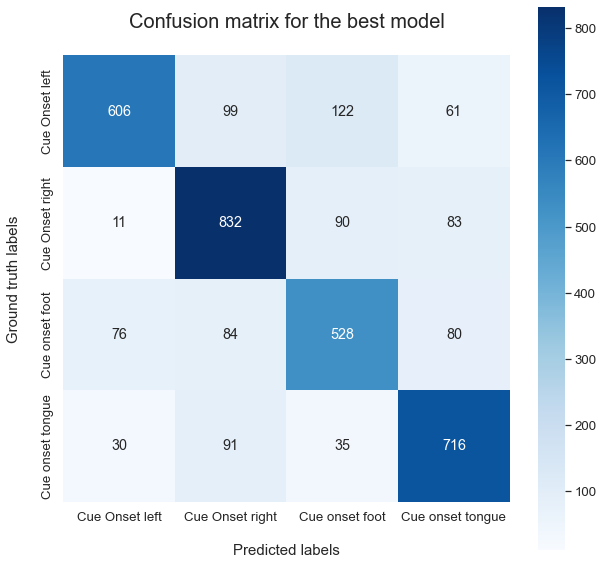

In [18]:
fig = plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
cm = sns.heatmap(df_cm, annot=True,fmt='g',cmap='Blues',xticklabels=True,yticklabels=True)
plt.title('Confusion matrix for the best model\n',fontsize=20)
plt.xlabel('\nPredicted labels',fontsize = 15)
plt.ylabel('Ground truth labels\n',fontsize = 15)
plt.savefig('cm.png',dpi=500)
plt.show()

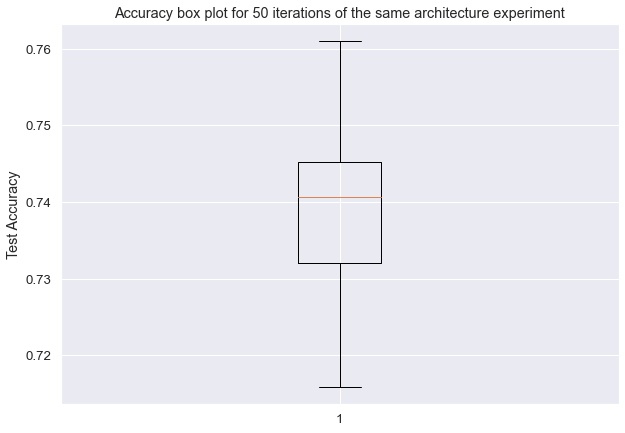

In [22]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(results)
plt.ylabel('Test Accuracy')
plt.title('Accuracy box plot for 50 iterations of the same architecture experiment')
# show plot
plt.show()